# Настройка

In [1]:
# pip install lpips

In [3]:
import os
import sys
sys.path.append('scripts')

import pandas as pd
import numpy as np

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, utils
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm


from dataset import negatives_dataset, negatives_loader, positives_dataset, positives_loader
from vae_model import VAE
from train_epoch import train_epoch
from loss import loss_function
from comparison import apply_model, draw_image, anomaly_detection

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /tmp/xdg_cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 95.3MB/s] 


Loading model from: /home/jupyter/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [4]:
model_name = 'vae128'
version = '002'

params = {
    'isize': 128,
    'nz': 100,
    'lr': 5e-5,
    'patience': 5,
}

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
assert device == 'cuda'

In [11]:
checkpoint_path = f'results/{model_name}_checkpoints/model_{version}.pt'
optimizer_path = f'results/{model_name}_checkpoints/optim_{version}.pt'
samples_dir = f'results/{model_name}_samples'

In [12]:
model = VAE(isize=params['isize'], nz=params['nz']).to(device)

# Обучение

In [8]:
# import wandb

# wandb.login(key='514eb1383ebf19dfe33c9834438026c917300873')
# wandb.init( project='arch_googlemaps_vae', name=f'{model_name}_v{version}')

In [9]:
# n_epochs = 30

# with tqdm(total=epochs*len(loader), desc=f"[REC: ?] [REG: ?]") as pbar:
#   for epoch in range(1, n_epochs + 1):
#       train_epoch(pbar, num_epoch, loss_function, checkpoint_path, optimizer_path, samples_dir)

# Метрики качетсва

In [13]:
model.load_state_dict(torch.load(checkpoint_path))

FileNotFoundError: [Errno 2] No such file or directory: 'results/vae128_checkpoints/model_002.pt'

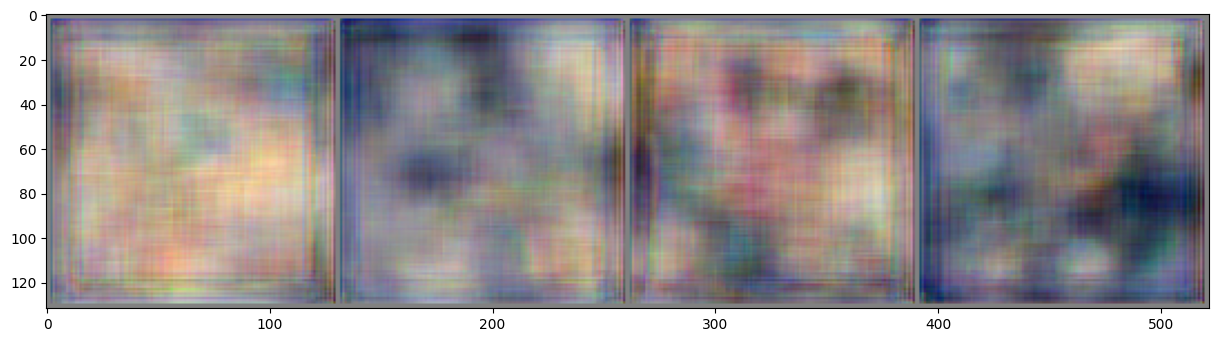

In [11]:
with torch.no_grad():
    sample = model.sample(4).cpu()
    log_img = make_grid(sample)
plt.figure(figsize=(15, 15))
plt.imshow((log_img.permute(1,2,0) - log_img.min()) / (log_img.max() - log_img.min()));

In [12]:
examples, reconstructions, titles = apply_model(model)

len(examples)=5


In [13]:
titles

['neg', 'neg', 'pos', 'pos', 'extra']

torch.Size([2, 5, 3, 128, 128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

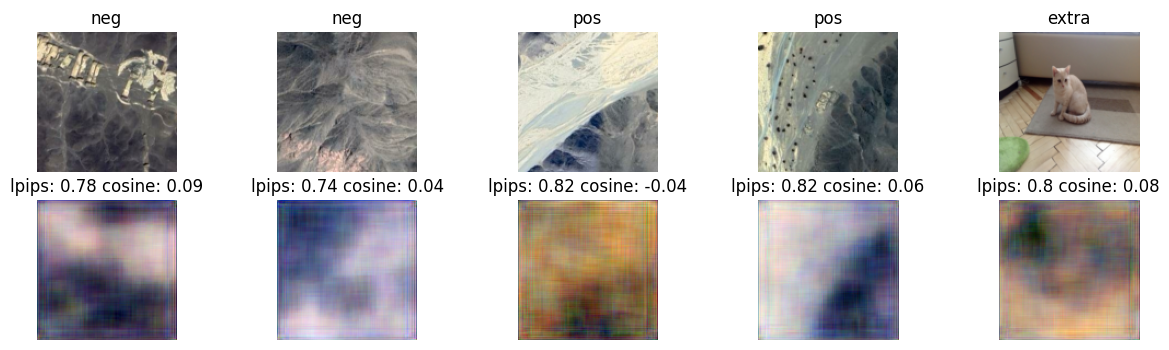

In [14]:
anomaly_detection(examples, reconstructions, titles)